In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/rf-tv-dataset/cleaned_tv_dataset_fi.csv


In [9]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedKFold, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

# Đảm bảo các kết quả reproducible
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Load dữ liệu & xem sơ bộ

In [10]:

df = pd.read_csv("/kaggle/input/rf-tv-dataset/cleaned_tv_dataset_fi.csv")

print("Kích thước dữ liệu:", df.shape)
display(df.head())

print("\nKiểu dữ liệu các cột:")
print(df.dtypes)

print("\nSố lượng giá trị thiếu mỗi cột:")
print(df.isna().sum())


Kích thước dữ liệu: (613, 12)


,price,spec_Backlight_Type,spec_Brand,spec_Display_Type,spec_ENERGY_STAR_Certified,spec_High_Dynamic_Range_HDR,spec_LED_Panel_Type,spec_Model_Year,spec_Refresh_Rate,spec_Remote_Control_Type,spec_Resolution,spec_Screen_Size_Class
0,139.99,Direct Lit,Pioneer,LED,No,Yes,Standard LED,2023,60,Voice control,4K (2160p),43
1,99.99,Direct Lit,TCL,LED,No,No,Standard LED,2025,144,Standard,Full HD (1080p),40
2,109.99,Direct Lit,Insignia,LED,No,No,Standard LED,2025,120,Voice control,Full HD (1080p),40
3,199.99,Direct Lit,Insignia,LED,No,Yes,Standard LED,2025,120,Voice control,4K (2160p),55
4,189.99,Direct Lit,Pioneer,LED,No,Yes,Standard LED,2023,60,Voice control,4K (2160p),50



Kiểu dữ liệu các cột:
price                          float64
spec_Backlight_Type             object
spec_Brand                      object
spec_Display_Type               object
spec_ENERGY_STAR_Certified      object
spec_High_Dynamic_Range_HDR     object
spec_LED_Panel_Type             object
spec_Model_Year                  int64
spec_Refresh_Rate                int64
spec_Remote_Control_Type        object
spec_Resolution                 object
spec_Screen_Size_Class           int64
dtype: object

Số lượng giá trị thiếu mỗi cột:
price                            0
spec_Backlight_Type            207
spec_Brand                       0
spec_Display_Type                0
spec_ENERGY_STAR_Certified       0
spec_High_Dynamic_Range_HDR      0
spec_LED_Panel_Type              0
spec_Model_Year                  0
spec_Refresh_Rate                0
spec_Remote_Control_Type         0
spec_Resolution                  0
spec_Screen_Size_Class           0
dtype: int64


# Tiền xử lý chung

In [11]:

target_col = "price"
y = df[target_col]
X = df.drop(columns=[target_col])

# Phân loại cột số và cột phân loại
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Số cột numeric:", len(numeric_cols))
print("Số cột categorical:", len(categorical_cols))

# Xử lý missing:
#  - numeric: điền median
#  - categorical: điền 'Unknown'
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
X[categorical_cols] = X[categorical_cols].fillna("Unknown")

# One-Hot Encoding các cột phân loại
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Kích thước X sau One-Hot encoding:", X_encoded.shape)

# Train/Test Split - Percentage Split (PS)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, " - Test size:", X_test.shape)


Số cột numeric: 3
Số cột categorical: 8
Kích thước X sau One-Hot encoding: (613, 58)
Train size: (490, 58)  - Test size: (123, 58)


# Hàm đánh giá mô hình (MAE, RMSE, R²)

In [12]:
def evaluate_regression(y_true, y_pred, model_name="Model"):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)
    print(f"===== {model_name} =====")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R²   : {r2:.4f}")
    return {"Model": model_name, "MAE": mae, "RMSE": rmse, "R2": r2}

# Random Forest với Percentage Split

In [13]:

rf_base = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

metrics_base = evaluate_regression(y_test, y_pred_base, model_name="RF Baseline (PS)")


===== RF Baseline (PS) =====
MAE  : 241.2488
RMSE : 411.7849
R²   : 0.7304


# Thiết lập Repeated K-Fold & bộ scoring cho Cross Validation

In [14]:
rkf = RepeatedKFold(
    n_splits=5,
    n_repeats=3,
    random_state=RANDOM_STATE
)

# Bộ scoring để dùng cho cross_validate
def rmse_scorer(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

scoring = {
    "MAE": make_scorer(mean_absolute_error, greater_is_better=False),
    "RMSE": make_scorer(rmse_scorer, greater_is_better=False),
    "R2": "r2"
}


# Repeated K-Fold Cross Validation cho RF Baseline

In [15]:

cv_results_base = cross_validate(
    rf_base,
    X_train,
    y_train,
    cv=rkf,         
    scoring=scoring,
    n_jobs=-1
)

mae_cv_base  = -cv_results_base["test_MAE"].mean()
rmse_cv_base = -cv_results_base["test_RMSE"].mean()
r2_cv_base   =  cv_results_base["test_R2"].mean()

print("===== RF Baseline - Repeated K-Fold CV (trên tập TRAIN) =====")
print(f"MAE  (mean over folds): {mae_cv_base:.4f}")
print(f"RMSE (mean over folds): {rmse_cv_base:.4f}")
print(f"R²   (mean over folds): {r2_cv_base:.4f}")
print("R² từng lần CV:", cv_results_base["test_R2"])


===== RF Baseline - Repeated K-Fold CV (trên tập TRAIN) =====
MAE  (mean over folds): 311.2400
RMSE (mean over folds): 482.2753
R²   (mean over folds): 0.6257
R² từng lần CV: [0.71965193 0.71656821 0.59536117 0.65375314 0.55468779 0.64754936
 0.64842557 0.69090787 0.43939359 0.62149356 0.59211437 0.54441193
 0.57604683 0.75316496 0.63139255]


# Bảng so sánh RF Baseline: PS vs CV

In [16]:

comparison_rows = []

# Kết quả Percentage Split (test set)
comparison_rows.append({
    "Model": "RF Baseline",
    "Eval": "Percentage Split (test 20%)",
    "MAE": metrics_base["MAE"],
    "RMSE": metrics_base["RMSE"],
    "R2": metrics_base["R2"]
})

# Kết quả Repeated K-Fold CV (trên tập train)
comparison_rows.append({
    "Model": "RF Baseline",
    "Eval": "Repeated K-Fold CV (train)",
    "MAE": mae_cv_base,
    "RMSE": rmse_cv_base,
    "R2": r2_cv_base
})

comparison_df = pd.DataFrame(comparison_rows)
comparison_df[["MAE", "RMSE", "R2"]] = comparison_df[["MAE", "RMSE", "R2"]].round(4)
display(comparison_df)


,Model,Eval,MAE,RMSE,R2
0,RF Baseline,Percentage Split (test 20%),241.2488,411.7849,0.7304
1,RF Baseline,Repeated K-Fold CV (train),311.2400,482.2753,0.6257


# Bảng chi tiết kết quả từng lần Repeated K-Fold cho RF Baseline

In [17]:
cv_detail_df = pd.DataFrame({
    "MAE": -cv_results_base["test_MAE"],
    "RMSE": -cv_results_base["test_RMSE"],
    "R2": cv_results_base["test_R2"]
})

cv_detail_df = cv_detail_df.round(4)
display(cv_detail_df)

print("MAE  mean ± std:", cv_detail_df["MAE"].mean(), "±", cv_detail_df["MAE"].std())
print("RMSE mean ± std:", cv_detail_df["RMSE"].mean(), "±", cv_detail_df["RMSE"].std())
print("R2   mean ± std:", cv_detail_df["R2"].mean(),  "±", cv_detail_df["R2"].std())

,MAE,RMSE,R2
0,276.3768,420.1989,0.7197
1,304.2095,441.1575,0.7166
2,338.0679,522.2676,0.5954
3,305.5106,481.2808,0.6538
4,316.8086,477.4426,0.5547
5,338.4736,523.3092,0.6475
6,325.8402,500.6964,0.6484
7,253.9338,403.3618,0.6909
8,356.5211,551.4805,0.4394
9,316.0716,487.9654,0.6215


MAE  mean ± std: 311.2400133333333 ± 32.60149358425309
RMSE mean ± std: 482.27533333333326 ± 45.19391488057194
R2   mean ± std: 0.6256666666666667 ± 0.08031717185781691


# Biểu đồ so sánh PS vs CV (MAE, RMSE, R²)

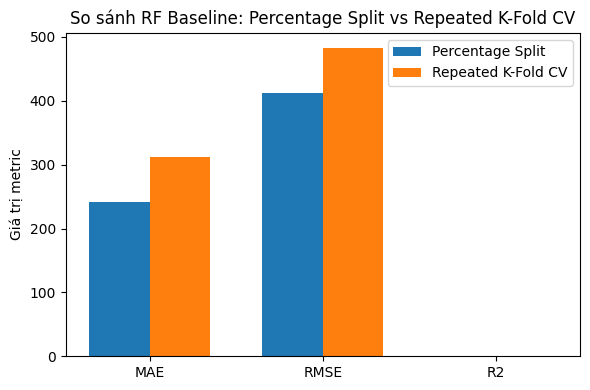

In [18]:

labels = ["MAE", "RMSE", "R2"]

ps_values = [
    metrics_base["MAE"],
    metrics_base["RMSE"],
    metrics_base["R2"]
]

cv_values = [
    mae_cv_base,
    rmse_cv_base,
    r2_cv_base
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6, 4))
plt.bar(x - width/2, ps_values, width, label="Percentage Split")
plt.bar(x + width/2, cv_values, width, label="Repeated K-Fold CV")

plt.xticks(x, labels)
plt.ylabel("Giá trị metric")
plt.title("So sánh RF Baseline: Percentage Split vs Repeated K-Fold CV")
plt.legend()
plt.tight_layout()
plt.show()


# SCATTER PLOT (Actual vs Predicted)

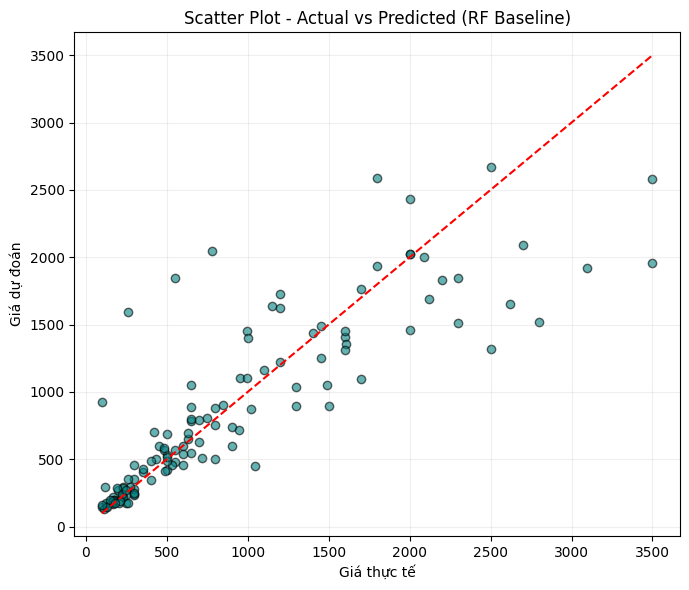

In [19]:

plt.figure(figsize=(7,6))

plt.scatter(y_test, y_pred_base, alpha=0.6, color="teal", edgecolor="k")

# Vẽ đường chéo lý tưởng
min_val = min(min(y_test), min(y_pred_base))
max_val = max(max(y_test), max(y_pred_base))
plt.plot([min_val, max_val], [min_val, max_val], "r--")

plt.xlabel("Giá thực tế")
plt.ylabel("Giá dự đoán")
plt.title("Scatter Plot - Actual vs Predicted (RF Baseline)")
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()


# Top đặc trưng ảnh hưởng nhất đến giá TV

,Feature,Importance
2,spec_Screen_Size_Class,0.383925
39,spec_LED_Panel_Type_Standard LED,0.135192
1,spec_Refresh_Rate,0.092519
28,spec_Display_Type_OLED,0.073376
0,spec_Model_Year,0.047547
4,spec_Backlight_Type_Full Array Local Dimming,0.026469
22,spec_Brand_Sony,0.023831
19,spec_Brand_Samsung,0.022278
47,spec_Remote_Control_Type_Standard,0.018135
29,spec_ENERGY_STAR_Certified_Yes,0.016180


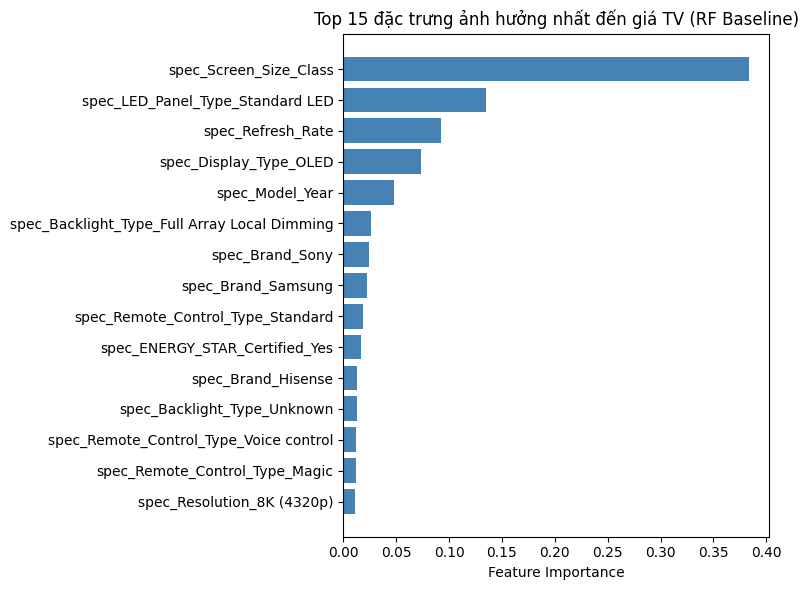

In [20]:

# Lấy importance từ RF Baseline
importances = rf_base.feature_importances_
feature_names = X_train.columns

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sắp xếp giảm dần
fi_df = fi_df.sort_values(by="Importance", ascending=False)

# Hiển thị bảng top 15
top15 = fi_df.head(15)
display(top15)

# Vẽ biểu đồ
plt.figure(figsize=(8,6))
plt.barh(top15["Feature"], top15["Importance"], color="steelblue")
plt.gca().invert_yaxis()   # để feature quan trọng nhất nằm trên
plt.xlabel("Feature Importance")
plt.title("Top 15 đặc trưng ảnh hưởng nhất đến giá TV (RF Baseline)")
plt.tight_layout()
plt.show()

In [21]:

import joblib
import json

# 1) Lưu model
joblib.dump(rf_base, "rf_model.pkl")
print("Đã lưu: rfmodel.pkl")

# 2) Lưu danh sách các cột sau One-Hot (cần thiết để deploy)
feature_cols = list(X_train.columns)
with open("rf_feature_columns.json", "w") as f:
    json.dump(feature_cols, f)

print("Đã lưu: rf_feature_columns.json")


Đã lưu: rfmodel.pkl
Đã lưu: rf_feature_columns.json
